In [290]:
import scipy
print('scipy: {}'.format(scipy.__version__)) # numpy
import numpy as np
print('numpy: {}'.format(np.__version__))
# matplotlib


import matplotlib 
import matplotlib.pyplot as plt
print('matplotlib: {}'.format(matplotlib.__version__)) # pandas
import pandas as pd
print('pandas: {}'.format(pd.__version__))
#scikit-learn
import sklearn
print('sklearn: {}'.format(sklearn.__version__))
import xlrd
from sklearn.preprocessing import Imputer

from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import Lasso, Ridge  
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.feature_selection import RFE
from sklearn import cross_validation
from sklearn.model_selection import GridSearchCV
from sklearn import model_selection #might be model_selection <--- this is the new one
from sklearn.preprocessing import Normalizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import RFECV
import seaborn as sns
import xgboost as xgb
sns.set_style("whitegrid")
%matplotlib inline

scipy: 0.19.1
numpy: 1.12.1
matplotlib: 2.0.2
pandas: 0.20.3
sklearn: 0.19.0


In [43]:
pd.set_option("display.max_columns",500)

In [291]:
data = pd.read_csv('SuperZooData/Registration_Data/SuperZoo_2016_Registrants_No_Minors.csv', header = 2)

In [292]:
test_data = pd.read_csv('SuperZooData/Registration_Data/SuperZoo_2017_Registrants_No_Minors.csv', header = 2)

In [95]:
def dups_with_dif_index_check(data):
    dupes = {}                        # checks to see if duplicated columns with different index values
    for col_a in data.columns:
        dupes[col_a] = []

        for col_b in data.columns:
            if col_b in dupes.keys():
                continue
            if (data.loc[:,col_a] == data.loc[:,col_b]).sum() == len(data.loc[:,col_a]):
                dupes[col_a].append(col_b)    
   
    bad_cols = []   
    for col, dup_cols in dupes.iteritems():
        bad_cols += dup_cols
    bad_cols = set(bad_cols)

    data = data.loc[:,~data.columns.isin(bad_cols)]
    return data

In [96]:
def clear_dups_na(data):
    data = data.loc[:,~data.columns.duplicated()] 
    data = data.dropna(axis=1, how='all')
    data = data.dropna(axis=0, how='all')
    data = dups_with_dif_index_check(data)
    return data

In [97]:
def data_drop_other_text(data):
    col = []
    for a in data:
        if "_text" in a or "_other" in a:
            col.append(a)
    data=data.drop(labels = col, axis =1)
    return data

In [98]:
def get_rid_of_nonnumerical_answer(data):
    col = [] # THIS NEEDS TO BE CHANGED FOR NEW DATA SET
    checker = 1
    for a in data.columns:
        if '_codes' in a and checker ==1:
            checker = 0
        if '_codes' not in a and checker == 0:
            col.append(a)
    data = data.drop(col, axis = 1)
    return data

In [99]:
def answers_dummies(data):
    column =[]
    for a in data.columns:
        if "_codes" in a:
            column.append(a)  
    for a in column:
        new_data = data[a].str.get_dummies(sep=',')
        data = pd.concat([data, new_data], axis=1)
        data = data.drop([a], axis = 1)
    return data
    

In [100]:
def data_change_string_drop_dups(data):
    for a in data.columns:
        if data[a].dtype== np.dtype('O'):
            data[a] = data[a].astype('S32')
    cols = list(data)    # THIS DROPS ALL COLUMNS THAT HAVE THE SAME VALUE
    nunique = data.apply(pd.Series.nunique)
    cols_to_drop = nunique[nunique == 1].index
    data = data.drop(cols_to_drop, axis=1)
    return data

In [101]:
def purchase_dummies(data):
    new_data = data['PurchaseItems'].str.get_dummies(sep=',')
    data = pd.concat([data, new_data], axis=1)
    data = data.drop(['PurchaseItems'], axis = 1)
    return data 

In [102]:
def state_dummies(data):
    s = data.State.value_counts()
    s = data.State.value_counts()[s > (8)].index #8
    holder = pd.get_dummies(data.State)
    holder_smaller = holder[s]
    data = pd.concat([data, holder_smaller], axis=1)
    return data

In [136]:
def email_change(data):
    for index, row in data.iterrows():
        try:
            data.loc[index, 'Email'] = data['Email'][index].split("@",1)[1]
        except:
            pass
    return data

In [104]:
def email_dummies(data):
    data = email_change(data)
    s = data.Email.value_counts()
    s = data.Email.value_counts()[s > (48)].index  #48
    holder = pd.get_dummies(data.Email)
    holder_smaller = holder[s]
    data = pd.concat([data, holder_smaller], axis=1)
    return data

In [105]:
def column_drops(data):
    data = data.drop(['WebUrl',"CheckInDate Date","Aux1", "Aux5","FirstPrintDate Time","FirstPrintLocId", 'FirstPrintStationId','CheckInDate Time',"ModifyDate Time", "IndexDate"], axis = 1)
    data = data.drop(['RegTypeDesc','SourceApp','CountryName','StreamSteps','StreamName', 'RegType','StreamStep',"AddUserId","ModifyUserId","AddDate Date","AddDate Time","ModifyDate Date"], axis = 1)
    data = data.drop(["Pwd", "UserName", "AccountKeyPublic","AccountKeyPrivate", "Notes",'Id', 'AccountId', 'ClientIp', 'StreamId','State', 'StreamStatus'], axis = 1)
    return data

In [106]:
def data_dummies(data):
    data = pd.get_dummies(data,columns = ['Aux6', 'ApprovalUserId', 'LangId', 'MemberStatus', 'TermsAccepted'], dummy_na = True)
    return data
    

In [107]:
def data_dummies_cleanup(data):
    d = {'3001': ['3001', '3001.1']}   
    data = data.rename(columns=lambda c: d[c].pop(0) if c in d.keys() else c)
    d = {'2001': ['2001', '2001.1']}
    data = data.rename(columns=lambda c: d[c].pop(0) if c in d.keys() else c)
    # renames duplicate column names
    d = {'TermsAccepted_nan': ['TermsAccepted_nan', 'TermsAccepted_nan.1']}
    data = data.rename(columns=lambda c: d[c].pop(0) if c in d.keys() else c)
    d = {'MemberStatus_nan': ['MemberStatus_nan', 'MemberStatus_nan.1']}
    data = data.rename(columns=lambda c: d[c].pop(0) if c in d.keys() else c)
    return data

In [108]:
def processing_data(data):
    data = data.apply(pd.to_numeric, errors='ignore')
    data = clear_dups_na(data)
    data = data_drop_other_text(data)
    data = get_rid_of_nonnumerical_answer(data)
    data = answers_dummies(data)
    data = data_change_string_drop_dups(data)
    data = purchase_dummies(data)
    data = state_dummies(data)
    data = email_dummies(data)
    data = column_drops(data)
    data = data_dummies(data)
    data = data_dummies_cleanup(data)
    return data

In [293]:
data = processing_data(data)

In [294]:
test_data = processing_data(test_data)

In [141]:
data.to_pickle("Data_Zoo.pkl")

In [142]:
test_data.to_pickle("Data_Zoo_test.pkl")

In [305]:
data = pd.read_pickle("Data_Zoo.pkl")

In [306]:
test_data = pd.read_pickle("Data_Zoo_test.pkl")

In [297]:
test_data.shape

(13444, 358)

In [298]:
data.shape

(16253, 361)

In [573]:
#(data.T.drop_duplicates(subset=data.index)).T  # to big of a dataset to use this to get rid of duplicate columns with different names

In [585]:
#for a in range(0,len(data.columns)):                                          # look at values of columns
#    if len(data.iloc[:,1])-data.iloc[:,a].isnull().sum() == 0:
#         print data.columns[a], len(data.iloc[:,1])-data.iloc[:,a].isnull().sum()

In [160]:
def y_for_train(train_data):
    y =[]
    for a in train_data['FirstPrintDate Date']:
        if a == 'nan':
            y.append(0)
        else:
            y.append(1)
    return y

In [161]:
def y_for_test(test_data):
    y =[]
    for a in test_data['FirstPrintDate Date']:
        if a == 'nan':
            y.append(0)
        else:
            y.append(1)
    return y

In [177]:
def train_test_column_sync(data, test_data):
    col=[]
    for a in data.columns:
        for b in test_data.columns:
            if a == b:
                col.append(b)    
    return col

In [150]:
def data_impute(X):
    data_X_hold = X.columns
    imp = Imputer(missing_values='NaN', strategy='mean', axis=1)
    imp.fit(X)
    data_T=imp.transform(X)
    X = pd.DataFrame(data_T, columns = data_X_hold)
    return X

In [299]:
def train_test_processing(data, test_data):
    train_Y = y_for_train(data)
    test_Y = y_for_test(test_data)
    train_X = data.select_dtypes(include = ['int64', 'float64', 'uint8']).iloc[:, 1:]
    test_X = test_data.select_dtypes(include = ['int64', 'float64', 'uint8']).iloc[:, 1:]
    col = train_test_column_sync(train_X, test_X)
    train_X = data[col]
    test_X = test_data[col]
    train_X = data_impute(train_X)
    test_X = data_impute(test_X)
    return (train_X, train_Y, test_X, test_Y)

In [307]:
train_X, train_Y, test_X, test_Y = train_test_processing(data, test_data)

In [186]:
import pandas_ml as pdml
import imblearn

In [308]:
train_Y = pd.DataFrame(train_Y)

In [309]:
data_normalized = pd.concat([train_X, train_Y], axis = 1)


In [310]:
data_normalized = pdml.ModelFrame(data_normalized, target = 0)

In [311]:
sampler = data_normalized.imbalance.over_sampling.SMOTE()
sampled = data_normalized.fit_sample(sampler)
sampled=pd.DataFrame(sampled)

In [312]:
sampled = sampled.sample(frac=1)
train_Y = sampled[0]
train_X = sampled.drop([0], axis = 1)

In [313]:
num_folds = 10
num_instances = len(train_X) 
seed = 7
scoring = 'roc_auc'

In [302]:
models=[]
models.append(('LR', LogisticRegression(random_state = seed)))
#models.append(('LASSO', Lasso())) 
#models.append(('Ridge', Ridge())) 
#models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('NB', GaussianNB()))
models.append(('KNeighborsClassifier', KNeighborsClassifier(n_neighbors =  25, weights = 'distance'))) 
models.append(('XGBClassifier', xgb.XGBClassifier()))
models.append(('GradientBoostingClassifier', GradientBoostingClassifier(random_state = seed)))
models.append(('AdaBoostClassifier', AdaBoostClassifier(random_state = seed)))
models.append(('RandomForestClassifier', RandomForestClassifier(random_state = seed)))
models.append(('ExtraTreesClassifier', ExtraTreesClassifier(random_state = seed)))
models.append(('DecisionTreeClassifier', DecisionTreeClassifier(random_state = seed)))
for name, model in models:
    kfold = model_selection.KFold(shuffle = True, n_splits=num_folds, random_state=seed)
    cv_results = model_selection.cross_val_score(model, train_X, train_Y, cv=kfold, scoring= scoring)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.524839 (0.009420)
NB: 0.491376 (0.012143)
KNeighborsClassifier: 0.684416 (0.013621)
XGBClassifier: 0.726516 (0.012144)
GradientBoostingClassifier: 0.727023 (0.012655)
AdaBoostClassifier: 0.715981 (0.009735)
RandomForestClassifier: 0.720782 (0.013313)
ExtraTreesClassifier: 0.708166 (0.012427)
DecisionTreeClassifier: 0.669955 (0.013454)


In [216]:
model = RandomForestClassifier(random_state = seed)
model.fit(train_X, train_Y)
#test_preds = model.predict(test_X)
array = model.predict(train_X)
probab = model.predict_proba(train_X)


In [898]:
probab[3]

array([ 0.24021084,  0.75978916])

In [217]:
unique_elements, counts_elements = np.unique(array, return_counts=True)  # this is predictions
print("Frequency of unique values of the said array:")
print(np.asarray((unique_elements, counts_elements)))

Frequency of unique values of the said array:
[[    0     1]
 [11825  9287]]


In [218]:
unique_elements, counts_elements = np.unique(train_Y, return_counts=True) #this is actual
print("Frequency of unique values of the said array:")
print(np.asarray((unique_elements, counts_elements)))

Frequency of unique values of the said array:
[[    0     1]
 [10556 10556]]


In [220]:
from sklearn.metrics import confusion_matrix

In [222]:
confusion_matrix(train_Y, array)

array([[9747,  809],
       [2078, 8478]], dtype=int64)

In [258]:
estimator = xgb.XGBClassifier()
rfe = RFECV(estimator,cv = kfold)
fit = rfe.fit(train_X,train_Y)
print("Num of feature: %d") % fit.n_features_
#print("Selected features: %s") % fit.support_
print("Feature Ranking: %s") % fit.ranking_

Num of feature: 65
Feature Ranking: [  1   1   1   1   1   1   1  12   1  25   1   1   1   1   1   1   1   1
   1   1   1   1   4  49   1   1   3   2  59   1   1   7  72  74  76  78
  80  82  84  86  88  90  92  94  96  98 100 102 104 106 108 110 112 114
 116 118 120 122 124 126 128 130 132 134 136 138 140 142 144 145 139 146
 148  53   1  29  27 163  19   1 169 171   1 174 176 179 178 153 155 157
   1   5   1 180 182 184 185   1 189   1  30  32  18   1   1  48  36  37
  34  54  55  38   1  42  44  56  60  62  67  10 150 158 160 164 186 190
 192 194   8   1 200 202 203 204   9 208 210 212 214 216 218 220 222 224
 226 228 230 232 234 236 238 240 241 239 237 235 233 231 229 227 225 223
 221 219 217 215 213 211 209 207 201 199 177 175 173 137 135 133 131 129
 127 125 123 121 119 117 115 113 111 109 107 105 103 101  99  97  95  93
  91  89  87  85  83  81  79  77  75  73  71  68  69  70  13   1  52   1
   1   1   1   1   1   1   1   1 147   1 172 151   1  22   1 161   1  39
 166 167   6 18

In [259]:
top_65_important_features = [] 
for b in range(0,len(fit.ranking_)):
    if fit.ranking_[b] == 1:
        top_65_important_features.append(b)
        print b,train_X.columns[b]

0 Phone2Number
1 FaxCountryPrefix
2 AmountBilled
3 AmountPaid
4 AmountDue
5 0201
6 0202
8 0204
10 0206
11 0207
12 0208
13 0209
14 0210
15 0211
16 0212
17 0213
18 0214
19 0215
20 0216
21 0217
24 0220
25 0221
29 0225
30 0226
74 3801
79 4101
82 4303
90 4314
92 4316
97 4322
99 4324
103 4329
104 4330
112 1002
129 1019
213 ATL
215 CON
216 CA
217 NV
218 AZ
219 TX
220 CO
221 WA
222 UT
223 FL
225 NY
228 MO
230 NJ
232 ON
240 GA
242 NC
250 OK
257 IA
274 MS
276 gmail.com
277 yahoo.com
278 aol.com
279 hotmail.com
284 comcast.net
290 Aux6_1.0
291 Aux6_nan
292 ApprovalUserId_0.0
293 ApprovalUserId_20.0
295 LangId_0.0
302 TermsAccepted_accepted


In [260]:
new_X = train_X.iloc[:,top_65_important_features]

In [261]:
X = new_X

In [262]:
top_65_important_features = X

In [263]:
models=[]
models.append(('LR', LogisticRegression(random_state = seed)))
#models.append(('LASSO', Lasso())) 
#models.append(('Ridge', Ridge())) 
#models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('NB', GaussianNB()))
models.append(('KNeighborsClassifier', KNeighborsClassifier())) 
models.append(('XGBClassifier', xgb.XGBClassifier()))
models.append(('GradientBoostingClassifier', GradientBoostingClassifier(random_state = seed)))
models.append(('AdaBoostClassifier', AdaBoostClassifier(random_state = seed)))
models.append(('RandomForestClassifier', RandomForestClassifier(random_state = seed)))
models.append(('ExtraTreesClassifier', ExtraTreesClassifier(random_state = seed)))
models.append(('DecisionTreeClassifier', DecisionTreeClassifier(random_state = seed)))
#models.append(('SVC', SVC(kernel = 'linear', random_state = seed)))
#models.append(('LinearSVR', LinearSVR(random_state = seed)))
for name, model in models:
    kfold = model_selection.KFold(shuffle = True, n_splits=num_folds, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X, train_Y, cv=kfold, scoring= scoring)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.526844 (0.010144)
NB: 0.486151 (0.009406)
KNeighborsClassifier: 0.722892 (0.007454)
XGBClassifier: 0.804854 (0.007700)
GradientBoostingClassifier: 0.807666 (0.007756)
AdaBoostClassifier: 0.772521 (0.008043)
RandomForestClassifier: 0.813782 (0.008067)
ExtraTreesClassifier: 0.806757 (0.007773)
DecisionTreeClassifier: 0.758981 (0.007442)


In [480]:
y_test = pd.DataFrame({'y': y})

In [271]:
Z=[]
Z=pd.concat([X,train_Y],axis=1)

In [272]:
corr = Z.select_dtypes(include = ['int64', 'float64','uint8']).iloc[:, 1:].corr()

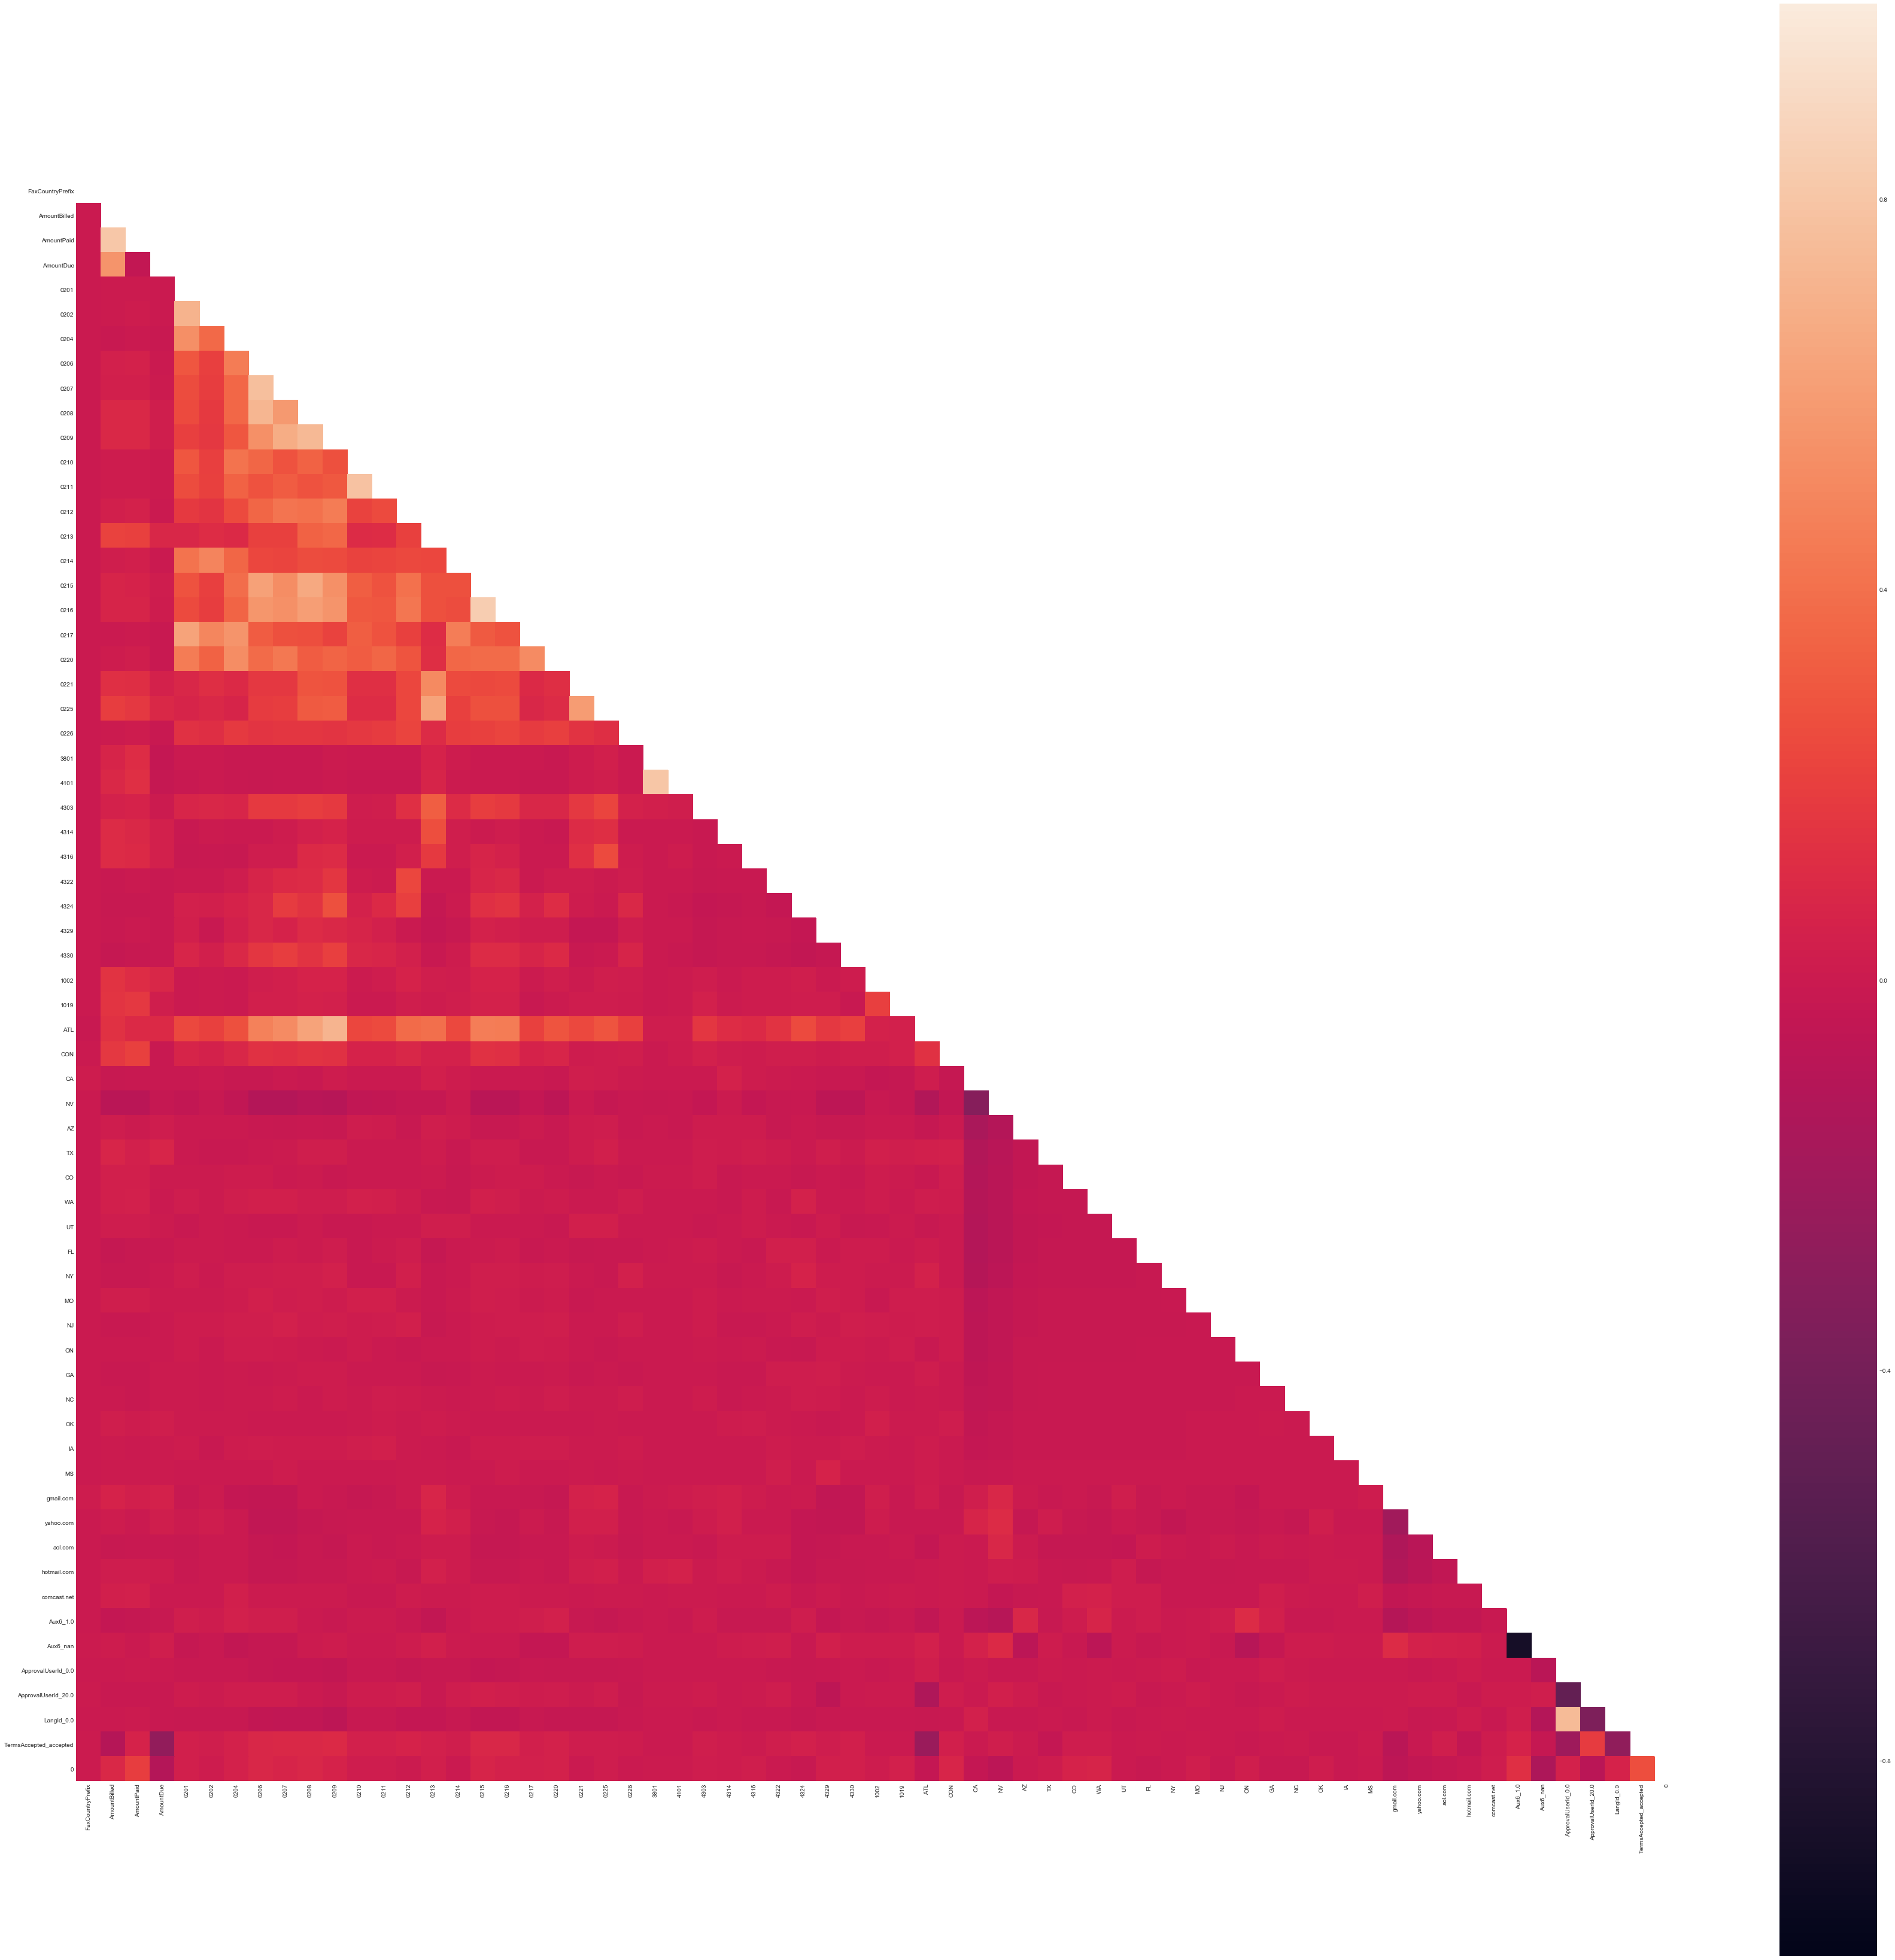

In [273]:
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(60, 60))
with sns.axes_style("white"):
    ax = sns.heatmap(corr, mask=mask, vmin = -1, vmax=1, square=True)

In [112]:

pd.set_option('display.max_columns', 500)

In [237]:
for a in range(0, len(models)):
    model1 = models[a]
    for b in range(a+1, len(models)):
        model2 = models[b]
        for c in range(b+1, len(models)):
            model3 = models[c]
            estimators = []
            estimators.append(model1)
            estimators.append(model2)
            estimators.append(model3)
            ensemble = VotingClassifier(estimators, voting='soft')
            results = model_selection.cross_val_score(ensemble, X, train_Y, cv=kfold, scoring= scoring)
            if results.mean() > .80:
                print(model1[0], model2[0], model3[0],results.mean(), results.std())


('LR', 'NB', 'XGBClassifier', 0.80373094511182885, 0.0074459607933667054)
('LR', 'NB', 'GradientBoostingClassifier', 0.80713897061068562, 0.0078512408350388599)
('LR', 'NB', 'RandomForestClassifier', 0.82051366423957095, 0.0067826765094150905)
('LR', 'NB', 'ExtraTreesClassifier', 0.8174011703123345, 0.0049786257282491819)
('LR', 'CART', 'XGBClassifier', 0.80893673369267893, 0.0063677302385076193)
('LR', 'CART', 'GradientBoostingClassifier', 0.8094223329283613, 0.0062800044189039034)
('LR', 'CART', 'RandomForestClassifier', 0.81054208304468178, 0.0063486744935278751)
('LR', 'CART', 'ExtraTreesClassifier', 0.8067311720566579, 0.0050780211636971429)
('LR', 'KNeighborsClassifier', 'GradientBoostingClassifier', 0.80098194320036475, 0.006733224410853219)
('LR', 'KNeighborsClassifier', 'RandomForestClassifier', 0.80875876278133385, 0.0064720190280071286)
('LR', 'KNeighborsClassifier', 'ExtraTreesClassifier', 0.80984221464294848, 0.0048449848855204661)
('LR', 'XGBClassifier', 'GradientBoosting

('XGBClassifier', 'AdaBoostClassifier', 'ExtraTreesClassifier', 0.8375869972229445, 0.0044279915984344487)
('XGBClassifier', 'AdaBoostClassifier', 'DecisionTreeClassifier', 0.8091061747279259, 0.0063735618787067365)
('XGBClassifier', 'RandomForestClassifier', 'ExtraTreesClassifier', 0.83796133242389548, 0.0049690712501052024)
('XGBClassifier', 'RandomForestClassifier', 'DecisionTreeClassifier', 0.82323529869688239, 0.005714240227708384)
('XGBClassifier', 'ExtraTreesClassifier', 'DecisionTreeClassifier', 0.82500181372507164, 0.0043426218027075294)
('GradientBoostingClassifier', 'AdaBoostClassifier', 'RandomForestClassifier', 0.83500381217148389, 0.0064748257368083548)
('GradientBoostingClassifier', 'AdaBoostClassifier', 'ExtraTreesClassifier', 0.83827040315951185, 0.0045667986291722173)
('GradientBoostingClassifier', 'AdaBoostClassifier', 'DecisionTreeClassifier', 0.80958828161984786, 0.0063097297172309517)
('GradientBoostingClassifier', 'RandomForestClassifier', 'ExtraTreesClassifier',

In [239]:
X.columns

Index([u'Phone2Number', u'FaxCountryPrefix', u'AmountBilled', u'AmountPaid',
       u'AmountDue', u'0201', u'0202', u'0203', u'0204', u'0205',
       ...
       u'Aux6_nan', u'ApprovalUserId_0.0', u'ApprovalUserId_20.0',
       u'LangId_0.0', u'LangId_1.0', u'MemberStatus_FullMember',
       u'MemberStatus_NonMember', u'MemberStatus_nan',
       u'TermsAccepted_accepted', u'TermsAccepted_nan'],
      dtype='object', length=206)

In [ ]:
RandomForestClassifier(random_state = seed)))
models.append(('ExtraTreesClassifier', ExtraTreesClassifier(random_state = seed)))

In [314]:
model = xgb.XGBClassifier()
model.fit(train_X,train_Y)
predict = model.predict(test_X)
probab = model.predict_proba(test_X)

In [315]:
print metrics.accuracy_score(test_Y, predict)
print metrics.roc_auc_score(test_Y, probab[:, 1])

0.704552216602
0.691885063062


In [242]:
from sklearn import metrics

In [240]:
estimators = []
estimators.append(('AdaBoostClassifier', AdaBoostClassifier(random_state = seed)))
estimators.append(('GradientBoostingClassifier', GradientBoostingClassifier(random_state = seed)))
estimators.append(('ExtraTreesClassifier', ExtraTreesClassifier(random_state = seed)))
ensemble = VotingClassifier(estimators, voting='soft')
ensemble.fit(X, train_Y)
predict = ensemble.predict(test_X[X.columns])
probab = ensemble.predict_proba(test_X[X.columns])

In [244]:
print metrics.accuracy_score(test_Y, predict)
print metrics.roc_auc_score(test_Y, probab[:, 1])

0.664831895269
0.663753383393


In [285]:
print metrics.confusion_matrix(test_Y, predict)
#print metrics.classification_report(test_Y, predict)

[[1559 2162]
 [1841 7882]]
